In [2]:
import os
import time
import matplotlib.pyplot as plt
import gc; gc.enable() # memory is tight
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tfx.v1 as tfx
import tensorflow_datasets as tfds
import ml_metadata as mlmd

from tensorflow import keras
from tensorflow_transform.tf_metadata import schema_utils

from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from typing import List
from google.cloud import bigquery, storage
from google.cloud import aiplatform as vertex_ai
from absl import logging

from ml_metadata.proto import metadata_store_pb2

from tfx.dsl.component.experimental.decorators import component
from tfx.types.experimental.simple_artifacts import Dataset
from tfx.types.standard_artifacts import String
from tfx.dsl.component.experimental.annotations import Parameter
from tfx.extensions.google_cloud_big_query.example_gen.component import BigQueryExampleGen
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx_bsl.public import tfxio
from tfx.proto import example_gen_pb2, transform_pb2
from tensorflow_metadata.proto.v0 import schema_pb2
from src.utils.common import rle_decode_tf

In [3]:
#!pip install -U tfx
#!pip install python-snappy
#!pip install apache-beam[interactive]

## TODO: To convert below to Argparse

In [4]:
PROJECT = 'mle-airbus-detection-smu' # Change to your project id.
PROJECT_NUMBER = '484894607141'
REGION = 'asia-east1' # Change to your region.
BUCKET = 'mle_airbus_dataset' # Change to your bucket name.
SERVICE_ACCOUNT = "service-account-for-mle@mle-airbus-detection-smu.iam.gserviceaccount.com"

if PROJECT == "" or PROJECT is None or PROJECT == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT = shell_output[0]
    
if SERVICE_ACCOUNT == "" or SERVICE_ACCOUNT is None or SERVICE_ACCOUNT == "[your-service-account]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.account)' 2>/dev/null
    SERVICE_ACCOUNT = shell_output[0]
    
if BUCKET == "" or BUCKET is None or BUCKET == "[your-bucket-name]":
    # Get your bucket name to GCP projet id
    BUCKET = PROJECT
    # Try to create the bucket if it doesn'exists
    ! gsutil mb -l $REGION gs://$BUCKET
    print("")
    
PARENT = f"projects/{PROJECT}/locations/{REGION}"

PIPELINE_NAME = 'airbusmlepipeline'

# Path to various pipeline artifact.
PIPELINE_ROOT = 'gs://{}/{}/pipeline_root'.format(
    BUCKET, PIPELINE_NAME)

# Paths for users' Python module.
MODULE_ROOT = 'gs://{}/{}/pipeline_module'.format(
    BUCKET, PIPELINE_NAME)

# Paths for users' data.
DATA_ROOT = 'gs://{}/{}/data'.format(BUCKET, PIPELINE_NAME)

# This is the path where your model will be pushed for serving.
SERVING_MODEL_DIR = 'gs://{}/{}/serving_model'.format(
    BUCKET, PIPELINE_NAME)

print('PIPELINE_ROOT: {}'.format(PIPELINE_ROOT))
print('MODULE_ROOT: {}'.format(MODULE_ROOT))
print('DATA_ROOT: {}'.format(DATA_ROOT))
print('SERVING_MODEL_DIR: {}'.format(SERVING_MODEL_DIR))

BQ_DATASET_NAME = 'mle-airbus-detection-smu.airbus_label_dataset' # Change to your BQ dataset name.
BQ_TABLE_NAME = 'airbus_label'
BQ_LOCATION = ' asia-east1'
    
print("Project ID:", PROJECT)
print("Region:", REGION)
print("Bucket name:", BUCKET)
print("Service Account:", SERVICE_ACCOUNT)
print("Vertex API Parent URI:", PARENT)

! gsutil ls -al "gs://"$BUCKET


storage_client = storage.Client(project=PROJECT)
bucket = storage_client.get_bucket(BUCKET)
storage_path = f"gs://{BUCKET}/train_v2/"
print (storage_path)

VERSION = 'v01'
DATASET_DISPLAY_NAME = 'airbus-ship-dataset-display'
MODEL_DISPLAY_NAME = f'{DATASET_DISPLAY_NAME}-classifier-{VERSION}'

WORKSPACE = f'gs://{BUCKET}/{DATASET_DISPLAY_NAME}'
EXPERIMENT_ARTIFACTS_DIR = os.path.join(WORKSPACE, 'experiments')

TENSORBOARD_DISPLAY_NAME = f'tb-{DATASET_DISPLAY_NAME}'
EXPERIMENT_NAME = f'{MODEL_DISPLAY_NAME}'

BATCH_SIZE = 16
EDGE_CROP = 16
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False
N_SAMPLE = 10
IMG_SHAPE = (768, 768)

PIPELINE_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/pipeline_root
MODULE_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/pipeline_module
DATA_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/data
SERVING_MODEL_DIR: gs://mle_airbus_dataset/airbusmlepipeline/serving_model
Project ID: mle-airbus-detection-smu
Region: asia-east1
Bucket name: mle_airbus_dataset
Service Account: service-account-for-mle@mle-airbus-detection-smu.iam.gserviceaccount.com
Vertex API Parent URI: projects/mle-airbus-detection-smu/locations/asia-east1
  45093109  2022-05-28T10:39:08Z  gs://mle_airbus_dataset/train_ship_segmentations_v2.csv#1653734348401267  metageneration=1
                                 gs://mle_airbus_dataset/train_v2/
TOTAL: 1 objects, 45093109 bytes (43 MiB)
gs://mle_airbus_dataset/train_v2/


In [5]:
%%bigquery masks

SELECT * FROM `mle-airbus-detection-smu.airbus_data.label_data`

Downloading: 100%|██████████| 231723/231723 [00:01<00:00, 205034.73rows/s]


In [6]:
QUERY = "SELECT * FROM `mle-airbus-detection-smu.airbus_data.label_data`"

In [7]:
masks.head()

,ImageId,EncodedPixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
2,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
3,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
4,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


# Experimental - TFX pipeline
### Setup BigQuery Pipeline

In [40]:
from src.tfx_pipelines.components import BigQueryReader
@component
def BigQueryReader(
    query: Parameter [str]
    ):
    bqclient = bigquery.Client()

    dataframe = (
        bqclient.query(query)
        .result()
        .to_dataframe(
            # Optionally, explicitly request to use the BigQuery Storage API. As of
            # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
            # API is used by default.
            create_bqstorage_client=True,
        )
    )
    print(dataframe.head())
    logging("test")

    
generator = BigQueryReader(query=QUERY)

# from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
# context = InteractiveContext()
# context.run(generator)
# # @component
# def MyTrainerComponent(
#     training_data: tfx.dsl.components.InputArtifact[tfx.types.standard_artifacts.Examples],
#     ) -> tfx.dsl.components.OutputDict(loss=object, accuracy=float):
#     '''My simple trainer component.'''

#     records = read_examples(training_data.uri)
#     model_obj = train_model(records, num_iterations, dropout_hyperparameter)
#     model_obj.write_to(model.uri)

#     return {
#     'loss': model_obj.loss,
#     'accuracy': model_obj.accuracy
#     }

ValueError: Component declared as a typehint-annotated function must have either an OutputDict instance or `None` as its return value typehint.

In [95]:
from typing import List, Optional

def _create_pipeline(
    pipeline_name: str, 
    pipeline_root: str, 
    query: str,
    module_file: str, 
    serving_model_dir: str,
    beam_pipeline_args: Optional[List[str]]) -> tfx.v1.dsl.Pipeline:
  """Creates a TFX pipeline using BigQuery."""

  generator = BigQueryReader(query=QUERY)

  components = [
    generator
  ]

  return tfx.v1.dsl.Pipeline(
    pipeline_name=pipeline_name,
    pipeline_root=pipeline_root,
    components=components)

In [96]:
# docs_infra: no_execute
import os

# We need to pass some GCP related configs to BigQuery. This is currently done
# using `beam_pipeline_args` parameter.
BIG_QUERY_WITH_DIRECT_RUNNER_BEAM_PIPELINE_ARGS = [
   '--project=' + f"'{PROJECT}'",
   '--temp_location=' + os.path.join('gs://', BUCKET, 'tmp')
   ]

PIPELINE_DEFINITION_FILE = PIPELINE_NAME + '_pipeline.json'

runner = tfx.v1.orchestration.experimental.KubeflowV2DagRunner(
    config=tfx.v1.orchestration.experimental.KubeflowV2DagRunnerConfig(),
    output_filename=PIPELINE_DEFINITION_FILE)
_ = runner.run(
    _create_pipeline(
        pipeline_name=PIPELINE_NAME,
        pipeline_root=PIPELINE_ROOT,
        query=QUERY,
        module_file=os.path.join(MODULE_ROOT, _trainer_module_file),
        serving_model_dir=SERVING_MODEL_DIR,
        beam_pipeline_args=BIG_QUERY_WITH_DIRECT_RUNNER_BEAM_PIPELINE_ARGS))

from google.cloud import aiplatform
from google.cloud.aiplatform import pipeline_jobs
import logging

logging.getLogger().setLevel(logging.INFO)

aiplatform.init(project=PROJECT, location=REGION)

job = pipeline_jobs.PipelineJob(template_path=PIPELINE_DEFINITION_FILE,
                                display_name=PIPELINE_NAME)
job.submit()

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/484894607141/locations/asia-east1/pipelineJobs/airbusmlepipeline-20220612024226


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/484894607141/locations/asia-east1/pipelineJobs/airbusmlepipeline-20220612024226


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/484894607141/locations/asia-east1/pipelineJobs/airbusmlepipeline-20220612024226')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/484894607141/locations/asia-east1/pipelineJobs/airbusmlepipeline-20220612024226')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/asia-east1/pipelines/runs/airbusmlepipeline-20220612024226?project=484894607141


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/asia-east1/pipelines/runs/airbusmlepipeline-20220612024226?project=484894607141


In [92]:


_trainer_module_file = 'penguin_trainer.py'

context = InteractiveContext(
  pipeline_name=PIPELINE_NAME,
  pipeline_root=PIPELINE_ROOT,
  metadata_connection_config=connection_config
)

In [18]:
beam_pipeline_args=[
    f"--project={PROJECT}",
    f"--temp_location={os.path.join(WORKSPACE, 'tmp')}"
]

print (train_example_gen.outputs['examples'])
# context.run(
#     train_example_gen,
#     beam_pipeline_args=beam_pipeline_args,
#     enable_cache=False
# )

OutputChannel(artifact_type=Examples, producer_component_id=BigQueryExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={})


In [14]:
train_uri = os.path.join(train_example_gen.outputs['examples'].get()[0].uri, "Split-train/*")
source_raw_schema = tfdv.load_schema_text(os.path.join(RAW_SCHEMA_DIR, 'schema.pbtxt'))
raw_feature_spec = schema_utils.schema_as_feature_spec(source_raw_schema).feature_spec

def _parse_tf_example(tfrecord):
    return tf.io.parse_single_example(tfrecord, raw_feature_spec)

tfrecord_filenames = tf.data.Dataset.list_files(train_uri)
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
dataset = dataset.map(_parse_tf_example)

for raw_features in dataset.shuffle(1000).batch(3).take(1):
    for key in raw_features:
        print(f"{key}: {np.squeeze(raw_features[key], -1)}")
    print("")

NameError: name 'tfdv' is not defined

In [13]:
%%writefile {_trainer_module_file}


from typing import List
from absl import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow_transform.tf_metadata import schema_utils

from tfx import v1 as tfx
from tfx_bsl.public import tfxio

from tensorflow_metadata.proto.v0 import schema_pb2

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy,BinaryCrossentropy 
from src.models.u_net import UNet_keras

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) #- dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)


_FEATURE_KEYS = [
    'ImageId'
]
_LABEL_KEY = 'EncodedPixels'

_TRAIN_BATCH_SIZE = 20
_EVAL_BATCH_SIZE = 10

_FEATURE_SPEC = {
    **{
        feature: tf.io.FixedLenFeature(shape=[1], dtype=tf.strings)
           for feature in _FEATURE_KEYS
       },
    _LABEL_KEY: tf.io.FixedLenFeature(shape=[1], dtype=tf.strings)
}


def _input_fn(file_pattern: List[str],
              data_accessor: tfx.components.DataAccessor,
              schema: schema_pb2.Schema,
              batch_size: int) -> tf.data.Dataset:
  """Generates features and label for training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    schema: schema of the input data.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  return data_accessor.tf_dataset_factory(
      file_pattern,
      tfxio.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_LABEL_KEY),
      schema=schema).repeat()

def _make_keras_model() -> tf.keras.Model:
  """Creates a DNN Keras model for classifying penguin data.

  Returns:
    A Keras Model.
  """
  # The model below is built with Functional API, please refer to
  # https://www.tensorflow.org/guide/keras/overview for all API options.

    model = UNet_keras()

    model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])
    model.summary(print_fn=logging.info)
    
    return model

def run_fn(fn_args: tfx.components.FnArgs):
  """Train the model based on given args.

  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """

  # This schema is usually either an output of SchemaGen or a manually-curated
  # version provided by pipeline author. A schema can also derived from TFT
  # graph if a Transform component is used. In the case when either is missing,
  # `schema_from_feature_spec` could be used to generate schema from very simple
  # feature_spec, but the schema returned would be very primitive.
  schema = schema_utils.schema_from_feature_spec(_FEATURE_SPEC)

  train_dataset = _input_fn(
      fn_args.train_files,
      fn_args.data_accessor,
      schema,
      batch_size=_TRAIN_BATCH_SIZE)
  eval_dataset = _input_fn(
      fn_args.eval_files,
      fn_args.data_accessor,
      schema,
      batch_size=_EVAL_BATCH_SIZE)

  model = _make_keras_model()
  model.fit(
      train_dataset,
      steps_per_epoch=fn_args.train_steps,
      epochs=5,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps)

  # The result of the training should be saved in `fn_args.serving_model_dir`
  # directory.
  model.save(fn_args.serving_model_dir, save_format='tf')


Overwriting penguin_trainer.py


In [ ]:
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# weight_path="{}_weights.best.hdf5".format('seg_model')

# checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
#                              save_best_only=True, mode='max', save_weights_only = True)

# reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
#                                    patience=3, 
#                                    verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
# early = EarlyStopping(monitor="val_dice_coef", 
#                       mode="max", 
#                       patience=15) # probably needs to be more patient, but kaggle time is limited
# callbacks_list = [checkpoint, early, reduceLROnPlat]

# step_count = min(MAX_TRAIN_STEPS, train_df_balanced.shape[0]//BATCH_SIZE)
# loss_history = [seg_model.fit(dataset, 
#                              steps_per_epoch=step_count, 
#                              epochs=NB_EPOCHS, 
#                              validation_data=validation,
#                              callbacks=callbacks_list,
#                             workers=1 # the generator is not very thread safe
#                                        )]

In [59]:
from typing import List, Optional

def _create_pipeline(pipeline_name: str, pipeline_root: str, query: str,
                     module_file: str, serving_model_dir: str,
                     beam_pipeline_args: Optional[List[str]],
                     ) -> tfx.dsl.Pipeline:
  """Creates a TFX pipeline using BigQuery."""

  # NEW: Query data in BigQuery as a data source.
  example_gen = tfx.extensions.google_cloud_big_query.BigQueryExampleGen(
      query=query)

  # Uses user-provided Python function that trains a model.
  trainer = tfx.components.Trainer(
      module_file=module_file,
      examples=example_gen.outputs['examples'],
      train_args=tfx.proto.TrainArgs(num_steps=100),
      eval_args=tfx.proto.EvalArgs(num_steps=5))

  # Pushes the model to a file destination.
  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))

  components = [
      example_gen,
      trainer,
      pusher,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      components=components,
      # NEW: `beam_pipeline_args` is required to use BigQueryExampleGen.
      beam_pipeline_args=beam_pipeline_args)

## Working Pipeline in Python that has yet to be migrated to TFX

In [9]:
masks['EncodedPixels'].replace(np.nan, '0', inplace=True)
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
# unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
masks.drop(['ships'], axis=1, inplace=True)

In [41]:
from sklearn.model_selection import train_test_split
train_ids, test_ids = train_test_split(unique_img_ids, 
                 test_size = 0.2, 
                 stratify = unique_img_ids['ships'])
train_ids, valid_ids = train_test_split(train_ids, 
                 test_size = 0.2, 
                 stratify = train_ids['ships']) 
train_df = pd.merge(masks, train_ids)
test_df = pd.merge(masks, test_ids)
valid_df = pd.merge(masks, valid_ids).sample(n=100)

print(train_df.shape[0], 'training masks')
print(test_df.shape[0], 'tests masks')
print(valid_df.shape[0], 'validation masks')

148304 training masks
46350 tests masks
100 validation masks


In [42]:
#rebalance label
from sklearn.utils import resample
#train_df['ships'].hist()

train_df_balanced = pd.DataFrame()
for ship_num in train_df['ships'].unique():
    train_df_balanced = train_df_balanced.append(resample(train_df.query("ships == {}".format(ship_num)), n_samples=N_SAMPLE))

train_df_balanced.reset_index(drop=True, inplace=True)

In [20]:
%%bigquery train_df

SELECT * FROM `mle-airbus-detection-smu.airbus_label_dataset.train`

Downloading: 100%|██████████| 148304/148304 [00:02<00:00, 63342.77rows/s] 


In [12]:
# from google.cloud import bigquery
# import pandas_gbq as pd_gbq


# # Construct a BigQuery client object.
# client = bigquery.Client()

# # TODO: Set project_id to your Google Cloud Platform project ID.
# project_id = "mle-airbus-detection-smu"

# # TODO: Set table_id to the full destination table ID (including the
# #       dataset ID).
# train_table_id = 'airbus_label_dataset.train'
# valid_table_id = 'airbus_label_dataset.valid'
# test_table_id = 'airbus_label_dataset.test'

# pd_gbq.to_gbq(train_df, train_table_id, project_id=project_id, if_exists='replace')
# pd_gbq.to_gbq(valid_df, valid_table_id, project_id=project_id, if_exists='replace')
# pd_gbq.to_gbq(test_df, test_table_id, project_id=project_id, if_exists='replace')

## Dataloader Pipeline

In [51]:
train_df_balanced

,ImageId,EncodedPixels,ships,has_ship
0,7231c10ba.jpg,174423 35 175157 69 175925 69 176693 69 177461...,5,1.0
1,a5d5d8a34.jpg,413185 3 413953 7 414721 12 415489 16 416257 2...,5,1.0
2,94e208d33.jpg,413538 6 414306 11 415074 11 415842 11 416610 ...,5,1.0
3,a5d5d8a34.jpg,413185 3 413953 7 414721 12 415489 16 416257 2...,5,1.0
4,012d9c145.jpg,126923 2 127691 4 128458 7 129226 8 129993 9 1...,5,1.0
...,...,...,...,...
145,15edd5fb8.jpg,178783 6 179551 11 180319 11 181087 11 181854 ...,14,1.0
146,e4ef760dd.jpg,416250 4 417018 7 417786 7 418553 8 419321 8 4...,14,1.0
147,3feaa0996.jpg,323942 1 324709 4 325477 5 326244 8 327011 11 ...,14,1.0
148,ed995c20f.jpg,339798 3 340566 7 341334 11 342101 13 342869 1...,14,1.0


In [52]:
from src.utils.dataset import parse_db_to_img

In [53]:
from tensorflow.keras import layers

data_reprocessing = tf.keras.Sequential(
    [
        layers.RandomFlip(),
        layers.RandomRotation(0.1),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1),
        layers.RandomZoom(0.9),
        layers.Rescaling(1.0 / 255),
        layers.Resizing(IMG_SHAPE[0], IMG_SHAPE[0])
    ]
)

dataset = tf.data.Dataset.from_tensor_slices((train_df_balanced['ImageId'].values, train_df_balanced['EncodedPixels'].values))
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.map(lambda x, y: parse_db_to_img(storage_path + x, y))
dataset = dataset.map(lambda x, y: (x, y))
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

validation = tf.data.Dataset.from_tensor_slices((valid_df['ImageId'].values, valid_df['EncodedPixels'].values))
validation = validation.shuffle(buffer_size=10)
validation = validation.map(parse_db_to_img)
validation = validation.batch(BATCH_SIZE)
validation = validation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

2022-06-12 06:41:20.802104: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


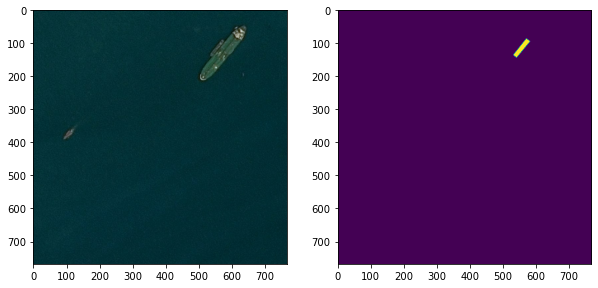

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for images, labels in dataset.take(1):
    images = images[0]
    labels = labels[0]
    ax[0] = ax[0].imshow(images)
    ax[1] = ax[1].imshow(labels)

## TODO: Clean up the code base and replace keras with TF for the U-net

In [45]:
from src.models.u_net import UNet_keras
seg_model = UNet_keras()

## TODO: Have not started on the below, simply copied and pasted . Need to clean them up toooooo.

In [46]:
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy,BinaryCrossentropy 

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) #- dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [47]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

step_count = min(MAX_TRAIN_STEPS, train_df_balanced.shape[0]//BATCH_SIZE)
loss_history = [seg_model.fit(dataset, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=validation,
                             callbacks=callbacks_list,
                            workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/5
1/9 [==>...........................] - ETA: 2:30 - loss: 6.2662e-04 - dice_coef: 0.0022 - binary_accuracy: 0.6925 - true_positive_rate: 0.3184

KeyboardInterrupt: 

In [ ]:
step_count = min(MAX_TRAIN_STEPS, train_df_balanced.shape[0]//BATCH_SIZE)
loss_history = [seg_model.fit(dataset, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=validation,
                             callbacks=callbacks_list,
                            workers=1 # the generator is not very thread safe
                                       )]